### 1) Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [49]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


From the table film: film_id, rental_rate, rental_duration, rating  
From the table film_categories: category_id  
From the table rental: rental_date   
Table inventory required as a link between tables

Possible: film.title, category.name


In [50]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [51]:
query = '''
SELECT F.film_id, F.title, F.length, F.rental_rate, F.rental_duration, F.rating, C.category_id, sub.rentals, sub.month, sub.year 
FROM sakila.film F
JOIN sakila.film_category C USING (film_id)
LEFT JOIN (
	SELECT 
		F.film_id,
		SUM((YEAR(R.rental_date) = 2005)) AS rentals,
		MONTH(R.rental_date) AS month,
		YEAR(R.rental_date) AS year
	FROM
		sakila.rental R
			JOIN
		sakila.inventory I USING (inventory_id)
			JOIN
		sakila.film F USING (film_id)
	WHERE
		(YEAR(R.rental_date) = 2005)
	GROUP BY F.film_id
) sub USING(film_id)
ORDER BY F.film_id;
'''
data = pd.read_sql_query(query, engine)
data

,film_id,title,length,rental_rate,rental_duration,rating,category_id,rentals,month,year
0,1,ACADEMY DINOSAUR,86,0.99,6,PG,6,23.0,7.0,2005.0
1,2,ACE GOLDFINGER,48,4.99,3,G,11,6.0,8.0,2005.0
2,3,ADAPTATION HOLES,50,2.99,7,NC-17,6,12.0,7.0,2005.0
3,4,AFFAIR PREJUDICE,117,2.99,5,G,11,22.0,7.0,2005.0
4,5,AFRICAN EGG,130,2.99,6,G,8,11.0,5.0,2005.0
...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,183,0.99,6,G,6,7.0,7.0,2005.0
996,997,YOUTH KICK,179,0.99,4,NC-17,12,6.0,7.0,2005.0
997,998,ZHIVAGO CORE,105,0.99,6,NC-17,11,8.0,6.0,2005.0
998,999,ZOOLANDER FICTION,101,2.99,5,R,3,17.0,7.0,2005.0


### 2) Create a query to get the list of films and a boolean indicating if it was rented last month (May 2005). This would be our target variable.

In [52]:
query2 = '''
SELECT 
    film.film_id, IF(ISNULL(sub1.month), False, True) AS rented_in_date
FROM
    sakila.film film
        LEFT JOIN
    (SELECT 
        F.film_id, MONTH(R.rental_date) AS month
    FROM
        sakila.rental R
    JOIN sakila.inventory I USING (inventory_id)
    JOIN sakila.film F USING (film_id)
    WHERE
        (YEAR(R.rental_date) = 2005) & (MONTH(R.rental_date) = 5)
    GROUP BY F.film_id) sub1 USING (film_id);
'''
data2 = pd.read_sql_query(query2, engine)
data2

,film_id,rented_in_date
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1
...,...,...
995,996,0
996,997,0
997,998,1
998,999,1


### 3) Read the data into a Pandas dataframe.

I need to filter the information in `data` by the month, to get only the rows in May:

In [53]:
# dataset = data.loc[data['month'] == 5]
# dataset

In [54]:
query3='''
SELECT F.film_id, F.title, F.length, F.rental_rate, F.rental_duration, F.rating, C.category_id, sub.rentals, sub.month, sub.year 
FROM sakila.film F
JOIN sakila.film_category C USING (film_id)
LEFT JOIN (
	SELECT 
		F.film_id,
		SUM((YEAR(R.rental_date) = 2005)) AS rentals,
		MONTH(R.rental_date) AS month,
		YEAR(R.rental_date) AS year
	FROM
		sakila.rental R
			JOIN
		sakila.inventory I USING (inventory_id)
			JOIN
		sakila.film F USING (film_id)
	WHERE
		(YEAR(R.rental_date) = 2005) & (MONTH(R.rental_date) = 5)
	GROUP BY F.film_id
) sub USING(film_id)
ORDER BY F.film_id;
'''
dataset =  pd.read_sql_query(query3, engine)
dataset

,film_id,title,length,rental_rate,rental_duration,rating,category_id,rentals,month,year
0,1,ACADEMY DINOSAUR,86,0.99,6,PG,6,2.0,5.0,2005.0
1,2,ACE GOLDFINGER,48,4.99,3,G,11,NaN,NaN,NaN
2,3,ADAPTATION HOLES,50,2.99,7,NC-17,6,1.0,5.0,2005.0
3,4,AFFAIR PREJUDICE,117,2.99,5,G,11,2.0,5.0,2005.0
4,5,AFRICAN EGG,130,2.99,6,G,8,1.0,5.0,2005.0
...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,183,0.99,6,G,6,NaN,NaN,NaN
996,997,YOUTH KICK,179,0.99,4,NC-17,12,NaN,NaN,NaN
997,998,ZHIVAGO CORE,105,0.99,6,NC-17,11,1.0,5.0,2005.0
998,999,ZOOLANDER FICTION,101,2.99,5,R,3,1.0,5.0,2005.0


In [55]:
data2

,film_id,rented_in_date
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1
...,...,...
995,996,0
996,997,0
997,998,1
998,999,1


In [56]:
data2['rented_in_date'].value_counts()

1    686
0    314
Name: rented_in_date, dtype: int64

### 4) Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [57]:
dataset.dtypes

film_id              int64
title               object
length               int64
rental_rate        float64
rental_duration      int64
rating              object
category_id          int64
rentals            float64
month              float64
year               float64
dtype: object

The columns `film_id` and `title` have the same information, as the id is the numerical representation of the title. As such, I can drop one of the two columns, and any of the will work as categorical during the rest of the algorithm.

In [58]:
dataset['rental_rate'].value_counts()

0.99    341
4.99    336
2.99    323
Name: rental_rate, dtype: int64

In [59]:
dataset['rental_duration'].value_counts()

6    212
3    203
4    203
7    191
5    191
Name: rental_duration, dtype: int64

The columns `rental_rate` and `rental_duration` show very few different values, so I was going to change them into objects, but I have realized that they will easier to handle as numbers.

In [60]:
dataset['rating'].value_counts()

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64

In [61]:
dataset['category_id'].value_counts()

15    74
9     73
8     69
6     68
2     66
1     64
13    63
7     62
14    61
10    61
3     60
5     58
4     57
16    57
11    56
12    51
Name: category_id, dtype: int64

These two columns are evenly distributed, so there is no need to cleam them.
`category_id` corresponds to the genre of the film, it would make sense to make it categorical.

In [62]:
dataset['category_id'] = dataset['category_id'].astype(object)

In [63]:
dataset['year'].value_counts()

2005.0    686
Name: year, dtype: int64

The column `year` has the same value in every row, so that is a drop.  
Also, I don't think the column `month` has anything important for the prediction, another thing to drop.  
`film_id`, being the same as `title`, is already in the target table, another drop.

In [64]:
dataset = dataset.drop(['film_id','title','year', 'month'], axis=1)
dataset.head()

,length,rental_rate,rental_duration,rating,category_id,rentals
0,86,0.99,6,PG,6,2.0
1,48,4.99,3,G,11,NaN
2,50,2.99,7,NC-17,6,1.0
3,117,2.99,5,G,11,2.0
4,130,2.99,6,G,8,1.0


In [65]:
dataset.dtypes

length               int64
rental_rate        float64
rental_duration      int64
rating              object
category_id         object
rentals            float64
dtype: object

In [66]:
dataset.isna().sum()

length               0
rental_rate          0
rental_duration      0
rating               0
category_id          0
rentals            314
dtype: int64

The remaining NaN values are the movies that have not been rented in that period. As such, it make sense to convert them to 0s.

In [67]:
dataset['rentals'] = dataset['rentals'].fillna(0)
dataset.isna().sum()

length             0
rental_rate        0
rental_duration    0
rating             0
category_id        0
rentals            0
dtype: int64

I'm going to have a look at the correlations with the target

In [68]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

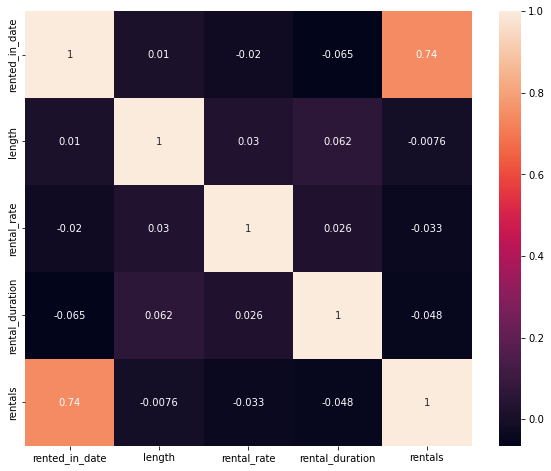

In [69]:
corr_table = pd.concat([data2['rented_in_date'], dataset], axis=1)

corr_matrix=corr_table.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

The highest correlation is with the `rentals` column. That makes sense because the target for this set is included in the column: If there is a value higher than 0 in `rentals`, that field will be 1 in the target and if it is 0 in `rentals` it will be 0 also in the target.
Due to this, have to drop it, as its effective correlation is 1.

In [70]:
dataset = dataset.drop(['rentals'], axis=1)

##### Train/Test Split
Before doing any transformation, I need to do the split between the sets.

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
y = data2['rented_in_date']
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, random_state=42)

##### Transformations
To be able to create a model, I need to transform the categorical columns into numerical columns.  
I will use the One Hot encoding for `rating` and `genre`, and the MinMax scaler for `rental_date` and `rental_duration`.  
To do that, first I have to separate the columns into numerical and categorical:

In [73]:
X_num = X_train.select_dtypes(include = np.number)
display(X_num)
X_cat = X_train.select_dtypes(include = 'object')
X_cat

,length,rental_rate,rental_duration
29,82,2.99,4
535,65,2.99,3
695,114,0.99,6
557,71,2.99,3
836,85,2.99,4
...,...,...,...
106,63,2.99,4
270,148,4.99,5
860,111,4.99,3
435,122,0.99,4


,rating,category_id
29,R,11
535,PG,4
695,NC-17,2
557,PG-13,13
836,PG,5
...,...,...
106,G,7
270,G,1
860,R,10
435,NC-17,13


##### OneHot

In [74]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder().fit(X_cat)


In [75]:
encoded_for_p = encoder.transform(X_cat).toarray()
cols = [colname for row in encoder.categories_ for colname in row]

onehot_table = pd.DataFrame(encoded_for_p, columns=cols)
cols_to_drop = [row[0] for row in encoder.categories_]

X_oh = onehot_table.drop(cols_to_drop,axis=1)
X_oh

,NC-17,PG,PG-13,R,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
798,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##### MinMax

In [76]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler().fit(X_num)

In [77]:
X_normalized = transformer.transform(X_num)
X_norm = pd.DataFrame(X_normalized)
X_norm.head()

,0,1,2
0,0.258993,0.5,0.25
1,0.136691,0.5,0.00
2,0.489209,0.0,0.75
3,0.179856,0.5,0.00
4,0.280576,0.5,0.25


In [78]:
transformed_data = pd.concat([X_norm, X_oh], axis=1)
transformed_data.head()

,0,1,2,NC-17,PG,PG-13,R,2,3,4,...,7,8,9,10,11,12,13,14,15,16
0,0.258993,0.5,0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.136691,0.5,0.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.489209,0.0,0.75,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.179856,0.5,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.280576,0.5,0.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5) Create a logistic regression model to predict this variable from the cleaned data.

In [79]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(transformed_data, y_train)

### 6) Evaluate the results. 


First I need to run the transformations in the test sets:

In [80]:
X_num_test = X_test.select_dtypes(include = np.number)
display(X_num_test)
X_cat_test = X_test.select_dtypes(include = 'object')
X_cat_test

,length,rental_rate,rental_duration
521,137,2.99,4
737,178,0.99,3
740,81,0.99,7
660,157,4.99,5
411,102,4.99,6
...,...,...,...
408,59,4.99,3
332,126,2.99,7
208,99,2.99,6
613,178,4.99,5


,rating,category_id
521,NC-17,5
737,PG-13,9
740,NC-17,12
660,PG-13,9
411,G,6
...,...,...
408,G,3
332,R,12
208,NC-17,7
613,PG-13,10


In [81]:
encoded_for_p = encoder.transform(X_cat_test).toarray()
cols = [colname for row in encoder.categories_ for colname in row]

onehot_table = pd.DataFrame(encoded_for_p, columns=cols)
cols_to_drop = [row[0] for row in encoder.categories_]

X_oh_test = onehot_table.drop(cols_to_drop,axis=1)
X_oh_test

,NC-17,PG,PG-13,R,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
X_normalized_test = transformer.transform(X_num_test)
X_norm_test = pd.DataFrame(X_normalized_test)
X_norm_test

,0,1,2
0,0.654676,0.5,0.25
1,0.949640,0.0,0.00
2,0.251799,0.0,1.00
3,0.798561,1.0,0.50
4,0.402878,1.0,0.75
...,...,...,...
195,0.093525,1.0,0.00
196,0.575540,0.5,1.00
197,0.381295,0.5,0.75
198,0.949640,1.0,0.50


In [83]:
X_test_transformed = np.concatenate([X_norm_test, X_oh_test], axis=1)

In [84]:
predictions = classification.predict(X_test_transformed)
# predictions
classification.score(X_test_transformed, y_test)

0.675

Expected result, as explained before the transformations.

### BONUS 7. Evaluate the results for June 2005

In [85]:
query4='''
SELECT F.film_id, F.title, F.length, F.rental_rate, F.rental_duration, F.rating, C.category_id, sub.rentals, sub.month, sub.year 
FROM sakila.film F
JOIN sakila.film_category C USING (film_id)
LEFT JOIN (
	SELECT 
		F.film_id,
		SUM((YEAR(R.rental_date) = 2005)) AS rentals,
		MONTH(R.rental_date) AS month,
		YEAR(R.rental_date) AS year
	FROM
		sakila.rental R
			JOIN
		sakila.inventory I USING (inventory_id)
			JOIN
		sakila.film F USING (film_id)
	WHERE
		(YEAR(R.rental_date) = 2005) & (MONTH(R.rental_date) = 6)
	GROUP BY F.film_id
) sub USING(film_id)
ORDER BY F.film_id;
'''
bonus =  pd.read_sql_query(query4, engine)
bonus

,film_id,title,length,rental_rate,rental_duration,rating,category_id,rentals,month,year
0,1,ACADEMY DINOSAUR,86,0.99,6,PG,6,3.0,6.0,2005.0
1,2,ACE GOLDFINGER,48,4.99,3,G,11,NaN,NaN,NaN
2,3,ADAPTATION HOLES,50,2.99,7,NC-17,6,1.0,6.0,2005.0
3,4,AFFAIR PREJUDICE,117,2.99,5,G,11,2.0,6.0,2005.0
4,5,AFRICAN EGG,130,2.99,6,G,8,2.0,6.0,2005.0
...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,183,0.99,6,G,6,1.0,6.0,2005.0
996,997,YOUTH KICK,179,0.99,4,NC-17,12,1.0,6.0,2005.0
997,998,ZHIVAGO CORE,105,0.99,6,NC-17,11,2.0,6.0,2005.0
998,999,ZOOLANDER FICTION,101,2.99,5,R,3,2.0,6.0,2005.0
